# Diabetes Prediction - Data Preprocessing

This notebook handles missing values, feature scaling, and train-test split.

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config
import utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(config.COLOR_PALETTE)

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Raw Data

In [2]:
# Load original dataset
df_original = utils.load_data()
print(f"\nOriginal dataset shape: {df_original.shape}")
df_original.head()

Dataset loaded: 768 rows, 9 columns

Original dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Handle Missing Values (Zeros)

In [3]:
print("Zeros in features (before imputation):")
print("="*60)
for feature in config.ZERO_AS_MISSING_FEATURES:
    zero_count = (df_original[feature] == 0).sum()
    print(f"{feature:25s}: {zero_count:3d} zeros")

# Apply median imputation
df_imputed = utils.handle_missing_values(df_original, strategy='median')

print("\nZeros in features (after imputation):")
print("="*60)
for feature in config.ZERO_AS_MISSING_FEATURES:
    zero_count = (df_imputed[feature] == 0).sum()
    print(f"{feature:25s}: {zero_count:3d} zeros")

Zeros in features (before imputation):
Glucose                  :   5 zeros
BloodPressure            :  35 zeros
SkinThickness            : 227 zeros
Insulin                  : 374 zeros
BMI                      :  11 zeros

Zeros in features (after imputation):
Glucose                  :   0 zeros
BloodPressure            :   0 zeros
SkinThickness            :   0 zeros
Insulin                  :   0 zeros
BMI                      :   0 zeros


## 3. Compare Distributions Before/After Imputation

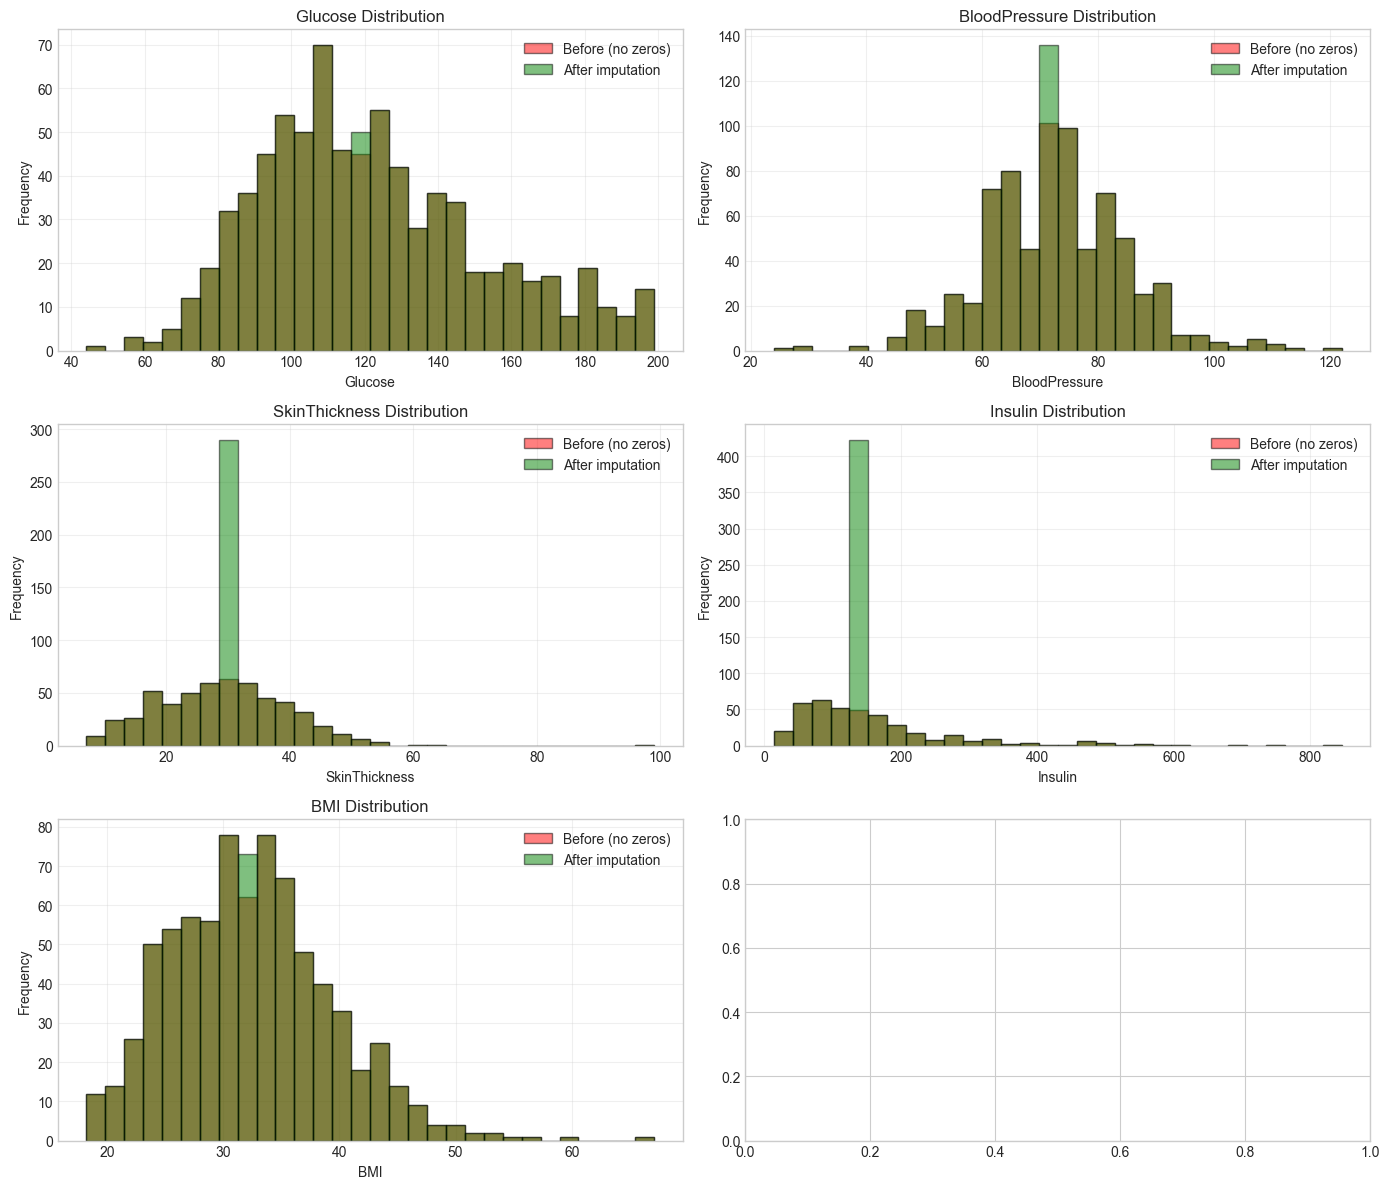

In [4]:
# Visualize changes from imputation
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, feature in enumerate(config.ZERO_AS_MISSING_FEATURES[:6]):
    ax = axes[idx]
    
    # Before imputation (excluding zeros)
    data_before = df_original[df_original[feature] > 0][feature]
    # After imputation
    data_after = df_imputed[feature]
    
    ax.hist(data_before, bins=30, alpha=0.5, label='Before (no zeros)', color='red', edgecolor='black')
    ax.hist(data_after, bins=30, alpha=0.5, label='After imputation', color='green', edgecolor='black')
    ax.set_title(f'{feature} Distribution')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/08_imputation_comparison.png', dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

## 4. Train-Test Split

In [5]:
# Separate features and target
X = df_imputed[config.FEATURE_NAMES]
y = df_imputed[config.TARGET_NAME]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=config.TEST_SIZE, 
    random_state=config.RANDOM_STATE,
    stratify=y
)

print(f"\nTrain set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")

# Verify stratification
print(f"\nTrain set diabetes rate: {y_train.mean()*100:.2f}%")
print(f"Test set diabetes rate: {y_test.mean()*100:.2f}%")
print(f"Overall diabetes rate: {y.mean()*100:.2f}%")

Features shape: (768, 8)
Target shape: (768,)

Train set size: 614 samples
Test set size: 154 samples

Train set diabetes rate: 34.85%
Test set diabetes rate: 35.06%
Overall diabetes rate: 34.90%


## 5. Feature Scaling

In [6]:
# Initialize and fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame for easier inspection
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=config.FEATURE_NAMES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=config.FEATURE_NAMES)

print(f"\nScaled train set - Mean (should be ~0):")
print(X_train_scaled_df.mean())
print(f"\nScaled train set - Std (should be ~1):")
print(X_train_scaled_df.std())


Scaled train set - Mean (should be ~0):
Pregnancies                -6.943414e-17
Glucose                    -1.099374e-16
BloodPressure               3.095606e-16
SkinThickness              -3.471707e-17
Insulin                    -4.339634e-18
BMI                        -1.148556e-15
DiabetesPedigreeFunction   -1.099374e-16
Age                        -1.084908e-16
dtype: float64

Scaled train set - Std (should be ~1):
Pregnancies                 1.000815
Glucose                     1.000815
BloodPressure               1.000815
SkinThickness               1.000815
Insulin                     1.000815
BMI                         1.000815
DiabetesPedigreeFunction    1.000815
Age                         1.000815
dtype: float64


## 6. Compare Unscaled vs Scaled Data

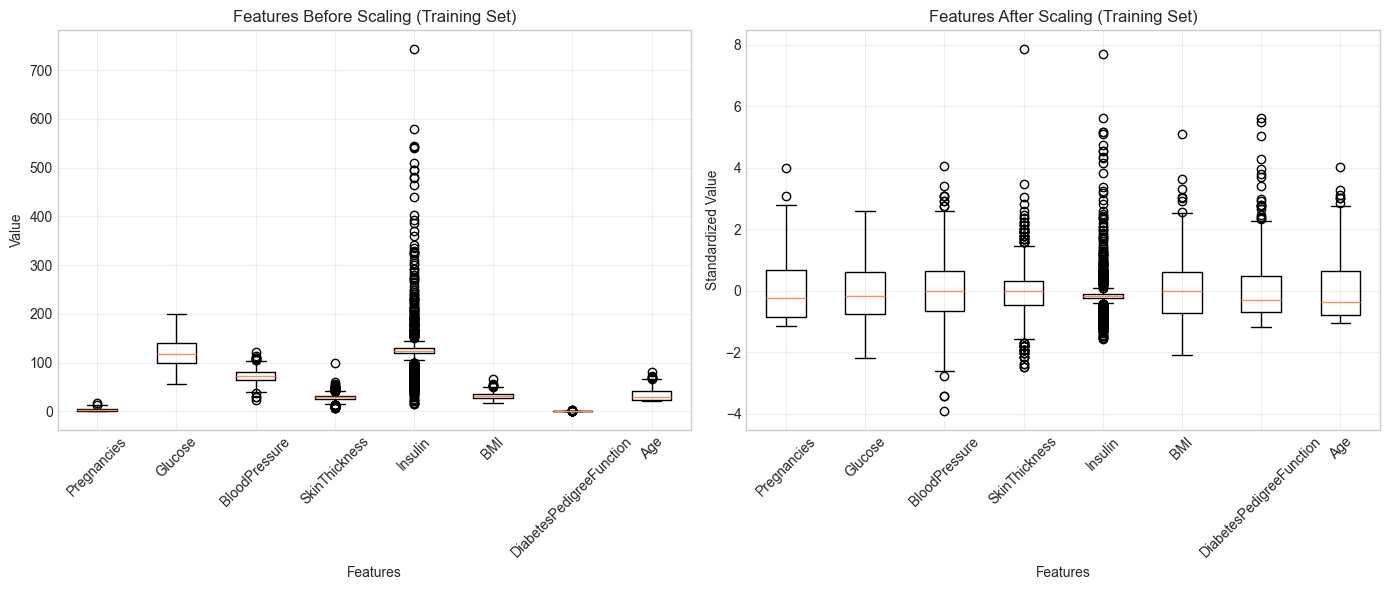

In [7]:
# Visualize scaling effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Before scaling
ax1.boxplot([X_train[col] for col in config.FEATURE_NAMES], labels=config.FEATURE_NAMES)
ax1.set_title('Features Before Scaling (Training Set)')
ax1.set_ylabel('Value')
ax1.set_xlabel('Features')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# After scaling
ax2.boxplot([X_train_scaled_df[col] for col in config.FEATURE_NAMES], labels=config.FEATURE_NAMES)
ax2.set_title('Features After Scaling (Training Set)')
ax2.set_ylabel('Standardized Value')
ax2.set_xlabel('Features')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/09_scaling_comparison.png', dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

## 7. Save Processed Data and Scaler

In [8]:
# Save scaler for future use
scaler_path = f'{config.MODELS_DIR}/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save processed datasets
np.save(f'{config.DATA_DIR}/X_train_scaled.npy', X_train_scaled)
np.save(f'{config.DATA_DIR}/X_test_scaled.npy', X_test_scaled)
np.save(f'{config.DATA_DIR}/y_train.npy', y_train.values)
np.save(f'{config.DATA_DIR}/y_test.npy', y_test.values)

print("\nProcessed data saved:")
print(f"  - X_train_scaled.npy ({X_train_scaled.shape})")
print(f"  - X_test_scaled.npy ({X_test_scaled.shape})")
print(f"  - y_train.npy ({y_train.shape})")
print(f"  - y_test.npy ({y_test.shape})")

Scaler saved to: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/models/scaler.pkl

Processed data saved:
  - X_train_scaled.npy ((614, 8))
  - X_test_scaled.npy ((154, 8))
  - y_train.npy ((614,))
  - y_test.npy ((154,))


## 8. Summary of Preprocessing Steps

In [9]:
print("\n" + "="*80)
print("DATA PREPROCESSING SUMMARY")
print("="*80)

print("\n1. MISSING VALUE HANDLING:")
print("   - Identified zeros as missing values in 5 features")
print("   - Applied median imputation strategy")
print("   - All zeros replaced with appropriate values")

print("\n2. TRAIN-TEST SPLIT:")
print(f"   - Training set: {len(X_train)} samples ({(len(X_train)/len(X))*100:.1f}%)")
print(f"   - Test set: {len(X_test)} samples ({(len(X_test)/len(X))*100:.1f}%)")
print(f"   - Stratified splitting maintained class distribution")

print("\n3. FEATURE SCALING:")
print("   - Applied StandardScaler (zero mean, unit variance)")
print("   - Fitted on training data only to prevent data leakage")
print("   - Same transformation applied to test data")

print("\n4. DATA SAVED:")
print("   - Scaled training and test sets saved as .npy files")
print("   - Scaler object saved for future predictions")

print("\n" + "="*80)
print("DATA IS NOW READY FOR MODEL TRAINING!")
print("="*80 + "\n")


DATA PREPROCESSING SUMMARY

1. MISSING VALUE HANDLING:
   - Identified zeros as missing values in 5 features
   - Applied median imputation strategy
   - All zeros replaced with appropriate values

2. TRAIN-TEST SPLIT:
   - Training set: 614 samples (79.9%)
   - Test set: 154 samples (20.1%)
   - Stratified splitting maintained class distribution

3. FEATURE SCALING:
   - Applied StandardScaler (zero mean, unit variance)
   - Fitted on training data only to prevent data leakage
   - Same transformation applied to test data

4. DATA SAVED:
   - Scaled training and test sets saved as .npy files
   - Scaler object saved for future predictions

DATA IS NOW READY FOR MODEL TRAINING!

